This Python Notebook creates, validates, and tests the RL environment of an incinerator using Stable-Baselines3 library [1]. The model derives from mass and energy balances, and hence, is a compartment of a thermodynamical material network [2],[3]. The model equations and the reward function are detailed in [4]. The ordinary differential equations are solved numerically using the Euler's method [5].

### References
[1] Stable-Baselines3 (SB3) documentation: https://stable-baselines3.readthedocs.io/en/master/

[2] Zocco, F., Sopasakis, P., Smyth, B. and Haddad, W.M., 2023. Thermodynamical material networks for modeling, planning, and control of circular material flows. International Journal of Sustainable Engineering, 16(1), pp.1-14.

[3] Zocco, F., Haddad, W.M., Corti, A. and Malvezzi, M., 2024. A Unification Between Deep-Learning Vision, Compartmental Dynamical Thermodynamics, and Robotic Manipulation for a Circular Economy. IEEE Access, pp. 173502-173516.

[4] Zocco, F., Corti, A. and Malvezzi, M., 2025. CiRL: Open-source environments for reinforcement learning in circular economy and
net zero. arXiv preprint arXiv:2505.21536.

[5] Euler's method for approximating the solution of ordinary differential equations: https://tutorial.math.lamar.edu/classes/de/eulersmethod.aspx


### Other Useful Reading
* Creating custom environment with SB3: https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html  

* Practical advices for creating custom environments with SB3: https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html#tips-and-tricks-when-creating-a-custom-environment

* To create this environment, I also followed the structure of the pendulum environment: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py

* Documentation of the pendulum environment: https://gymnasium.farama.org/environments/classic_control/pendulum/

* Formula for normalizing/de-normalizing the action space: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range  

* How to implement the normalization/de-normalization of the action space: https://github.com/hill-a/stable-baselines/issues/678

In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.3/185.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Creation of the environment class with its constituent functions:

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium import spaces

"""
    This environment is the incinerator model described in [1]. It is in the state-space form and consists of six first-order ordinary differential equations. Waste enters the
    incinerator, while ashes, char, and gases are the output flows. The incinerator compartment is divided into two sub-compartments: the wastebed and the freeboard. This model
    is a simplification of that developed in [2].

    Action: Q_ext (external heat)
    States/observations: waste mass, char mass, temperature in wastebed, gas mass in wastebed, gas mass in freeboard, gas temperature in freeboard

References:
    [1] Zocco, F., Corti, A. and Malvezzi, M., 2025. CiRL: Open-source environments for reinforcement learning in circular economy and net zero. arXiv preprint arXiv:2505.21536.
    [2] Magnanelli, E., Tranås, O.L., Carlsson, P., Mosby, J. and Becidan, M., 2020. Dynamic modeling of municipal solid waste incineration. Energy, 209, p. 118426.
"""

# Initial conditions:
M_ini = 0
M_char_ini = 0
T_w_ini = 20
M_g_w_ini = 0
M_g_f_ini = 0
T_g_ini = 20 #ambient temperature


class incinerator(gym.Env):

    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {"render_modes": ["console"]}



    def __init__(self, render_mode="console"):
        super(incinerator, self).__init__()
        self.render_mode = render_mode

        # Integration step size:
        self.dt = 0.00005

        # Model parameters:
        # For eq. 1:
        self.F_in = 100 #inlet waste
        self.F_out = 10 #outlet ashes
        self.R_w = 70 #consumption rate
        # For eq. 2:
        self.F_char_out = 2 #output flow of char
        self.P_char = 6 #production rate due to pyrolysis
        self.R_char = 3 #consumption rate due to combustion
        # For eq. 3:
        self.c_p_w = 1
        self.F_aI = 5
        self.c_p_g = 5
        self.T_aI = 20 #ambient temperature
        self.Q = 100 #exothermic reaction
        self.c_p = 1
        self.c_p_char = 1
        self.c_p_m = 25
        self.M_grate = 500
        # For eq. 4:
        self.F_g_w_out = 2
        self.R_g = 1 #production rate of gases due to combustion/pyrolysis
        # For eq. 5:
        self.F_g_out = 2
        self.F_aII = 3
        # For eq. 6:
        self.c_p_m = 5
        self.M_f_b = 120
        self.T_aII = 20
        self.Q_g = 450
        # Min and max of actions:
        self.Q_ext_min = -10**6
        self.Q_ext_max = 10**6
        # Min and max of states:
        self.M_min = 0
        self.M_max = np.inf
        self.M_char_min = 0
        self.M_char_max = np.inf
        self.T_w_min = 0
        self.T_w_max = np.inf
        self.M_g_w_min = 0
        self.M_g_w_max = np.inf
        self.M_g_f_min = 0
        self.M_g_f_max = np.inf
        self.T_g_min = 0
        self.T_g_max = np.inf

        # Parameters for reward function:
        self.T_g_desired = 1000 #degree Celsius

        # Define action and observation space with limits:
        min_values = np.array([self.M_min, self.M_char_min, self.T_w_min, self.M_g_w_min, self.M_g_f_min, self.T_g_min], dtype=np.float32)
        max_values = np.array([self.M_max, self.M_char_max, self.T_w_max, self.M_g_w_max, self.M_g_f_max, self.T_g_max], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(1,), dtype=np.float32
        ) # normalized between [-1, 1] as suggested in https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html

        self.observation_space = spaces.Box(low=min_values, high=max_values, dtype=np.float32)



    def step(self, Q_ext):  #Q_ext is the action

      M, M_char, T_w, M_g_w, M_g_f, T_g = self.state

      dt = self.dt
      F_in = self.F_in
      F_out = self.F_out
      R_w = self.R_w
      F_char_out = self.F_char_out
      P_char = self.P_char
      R_char = self.R_char
      c_p_w = self.c_p_w
      F_aI = self.F_aI
      c_p_g = self.c_p_g
      T_aI = self.T_aI
      Q = self.Q
      c_p = self.c_p
      c_p_char = self.c_p_char
      c_p_m = self.c_p_m
      M_grate = self.M_grate
      F_g_w_out = self.F_g_w_out
      R_g = self.R_g
      F_g_out = self.F_g_out
      F_aII = self.F_aII
      c_p_m = self.c_p_m
      M_f_b = self.M_f_b
      T_aII = self.T_aII
      Q_g = self.Q_g
      T_g_desired = self.T_g_desired
      Q_ext_min = self.Q_ext_min
      Q_ext_max = self.Q_ext_max

      # Clip and re-scale the action from [-1, 1] to [Q_ext_min, Q_ext_max] before the state-space equations:
      Q_ext = np.clip(Q_ext, -1, 1)[0] # convert 1-dim vector into scalar
      Q_ext = ((Q_ext-(-1))/(1-(-1)))*(Q_ext_max-Q_ext_min)+Q_ext_min # (general formula: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range)

      # State-space equations:
      M_dot = F_in-F_out-R_w #first state equation
      M_char_dot = -F_char_out+P_char-R_char #second state equation
      T_w_dot = (F_in*c_p_w*T_w+F_aI*c_p_g*(T_aI-T_w)+Q)/(c_p*M+c_p_char*M_char+c_p_m*M_grate) #third state equation
      M_g_w_dot = F_aI-F_g_w_out+R_g #fourth state equation
      M_g_f_dot = F_g_w_out-F_g_out+F_aII #fifth state equation
      T_g_dot = (F_g_w_out*c_p_g*(T_w-T_g)+F_aII*c_p_g*(T_aII-T_g)+Q_g-Q_ext)/(c_p_g*M_g_f+c_p_m*M_f_b)

      # update the states using Euler's method (approximation):
      M = M + M_dot*dt
      M_char = M_char + M_char_dot*dt
      T_w = T_w + T_w_dot*dt
      M_g_w = M_g_w + M_g_w_dot*dt
      M_g_f = M_g_f + M_g_f_dot*dt
      T_g = T_g + T_g_dot*dt

      # Reward, termination and truncation conditions:
      reward = - (T_g_desired - T_g)**2
      truncated = False # we do not limit the number of steps here, but in model.learn()
      terminated = False

      # Update the state:
      self.state = np.array([M, M_char, T_w, M_g_w, M_g_f, T_g])
      obs = self.state

      # Optionally we can pass additional info:
      info = {"Q_ext (action)": Q_ext}

      return obs.astype(np.float32), float(reward), truncated, terminated, info


    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(seed=seed, options=options)
        self.state = np.array([M_ini, M_char_ini, T_w_ini, M_g_w_ini, M_g_f_ini, T_g_ini], dtype=np.float32)

        return self.state, {}  # empty info dict



    def render(self):
        # Plot states vs. time:
        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_M, 'r-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (s)", fontsize=35)
        plt.ylabel(r"Waste mass, $M$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_M_char, 'b-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (s)", fontsize=35)
        plt.ylabel(r"Char mass, $M_{char}$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_T_w, 'g-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (min)", fontsize=35)
        plt.ylabel(r"Wastebed temperature, $T_w$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_M_g_w, 'k-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (min)", fontsize=35)
        plt.ylabel(r"Gas mass in wastebed, $M_{g,w}$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_M_g_f, 'k-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (min)", fontsize=35)
        plt.ylabel(r"Gas mass in freeboard, $M_{g,f}$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)

        fig = plt.figure(figsize=(10, 10))
        plt.plot(vector_t, vector_T_g, 'k-', linewidth=6)
        plt.grid()
        plt.xlabel(r"Time, $t$ (min)", fontsize=35)
        plt.ylabel(r"Gas temperature in freeboard, $T_g$", fontsize=35)
        plt.xticks(fontsize=35)
        plt.yticks(fontsize=35)


    def close(self):
        pass

### Validate the environment

Stable-Baselines3 provides a [helper](https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html) to check that your environment follows the Gym interface. It also optionally checks that the environment is compatible with Stable-Baselines3 (and emits warning if necessary).

In [ ]:
from stable_baselines3.common.env_checker import check_env

env = incinerator()
check_env(env, warn=True)

### Testing the environment

To test the environment, I compare its numerical solution with the one given by "integrate.odeint()" for the same initial conditions and for the same input Q_ext = 40.

I found that the 2 solutions are stable and very similar for dt = 0.00005. The solution is plotted below.

[ 0.  0. 20.  0.  0. 20.]
Box(0.0, inf, (6,), float32)
Box(-1.0, 1.0, (1,), float32)


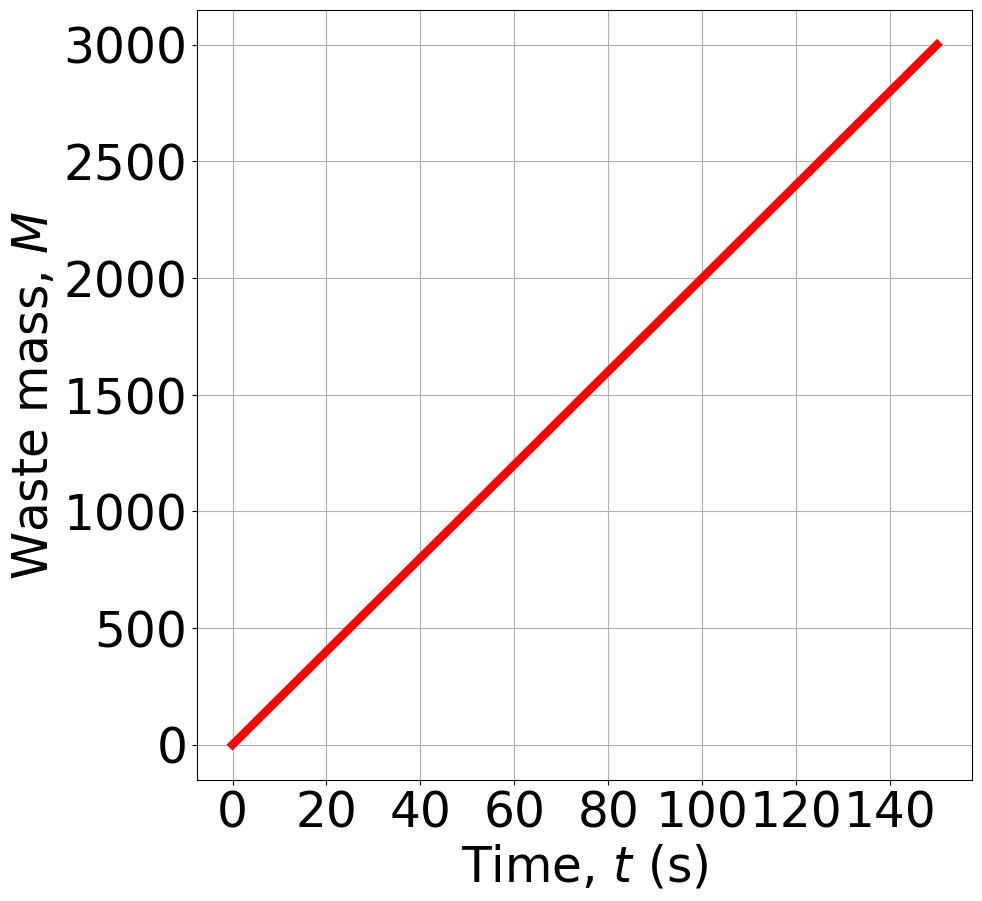

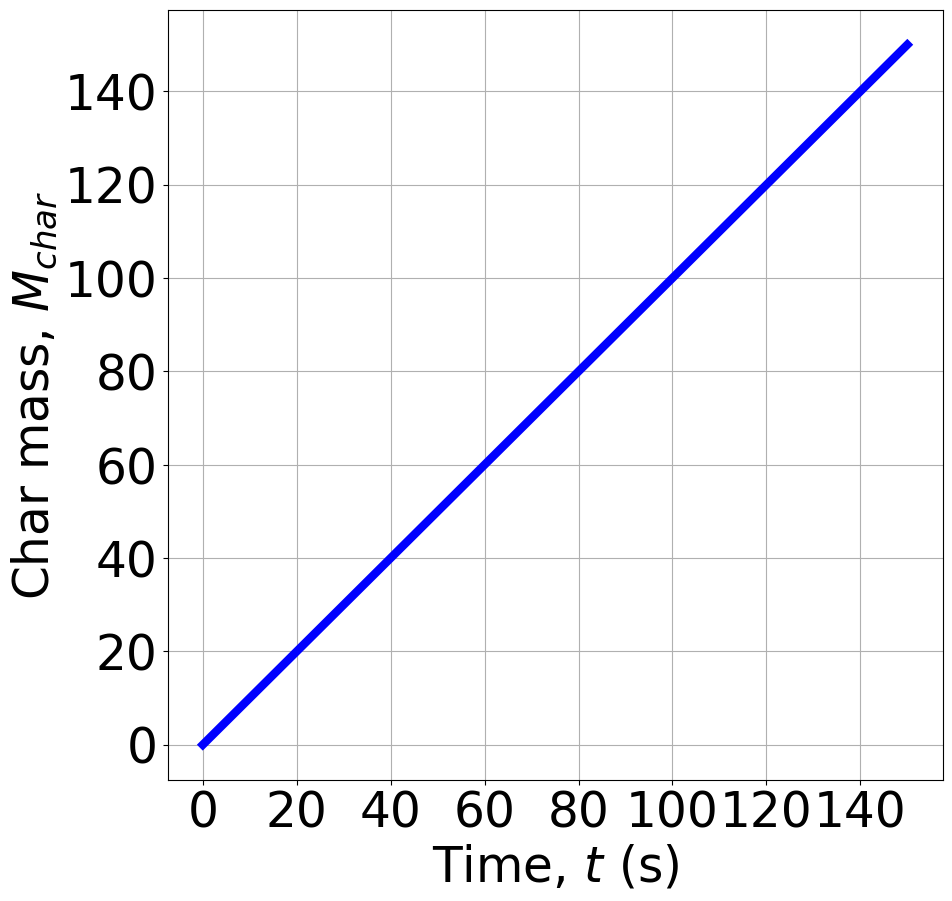

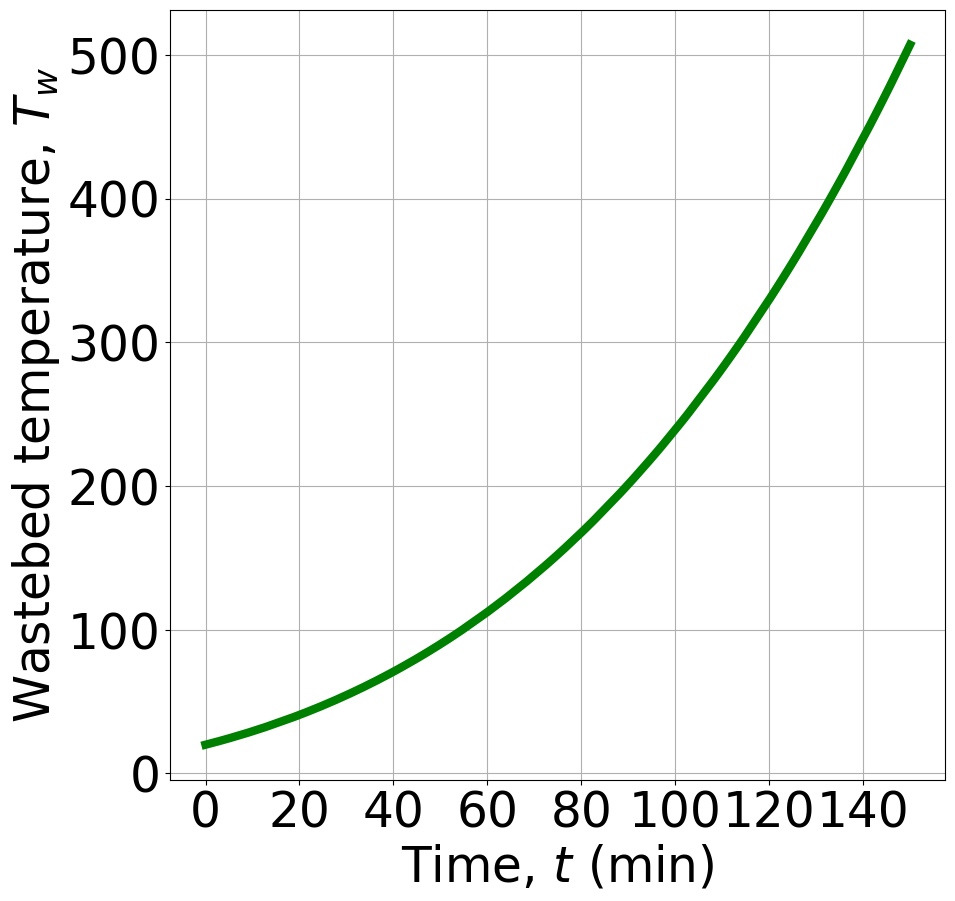

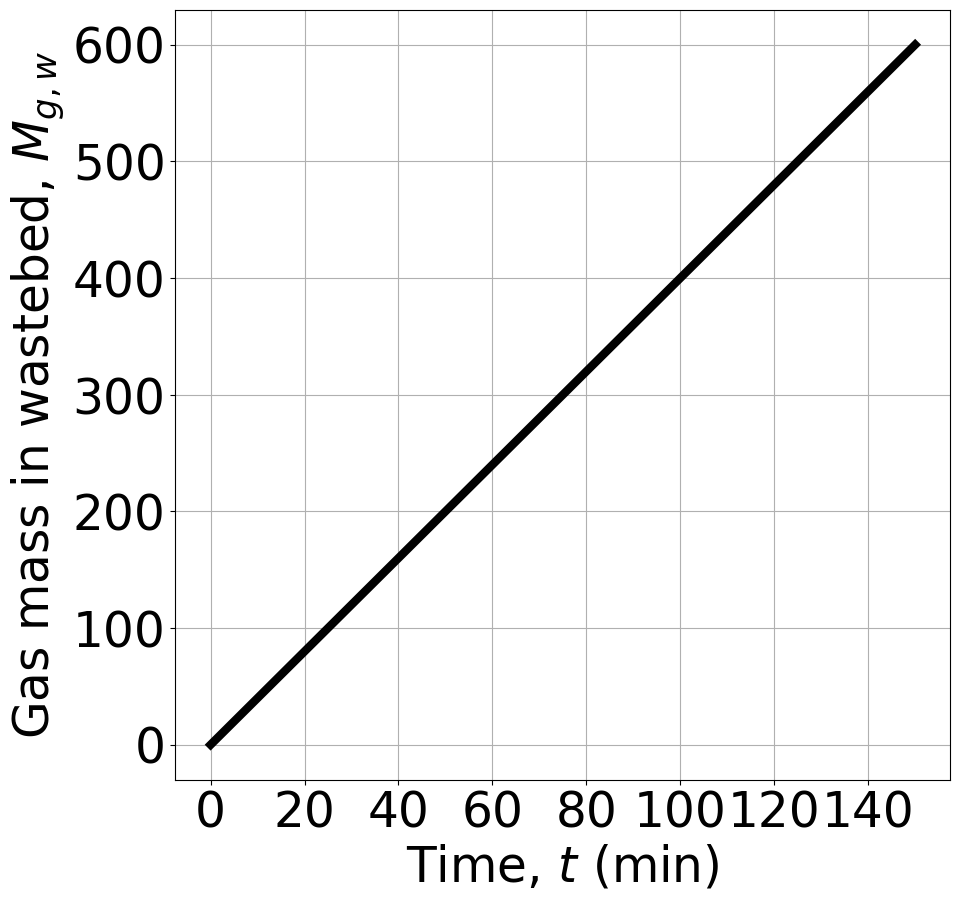

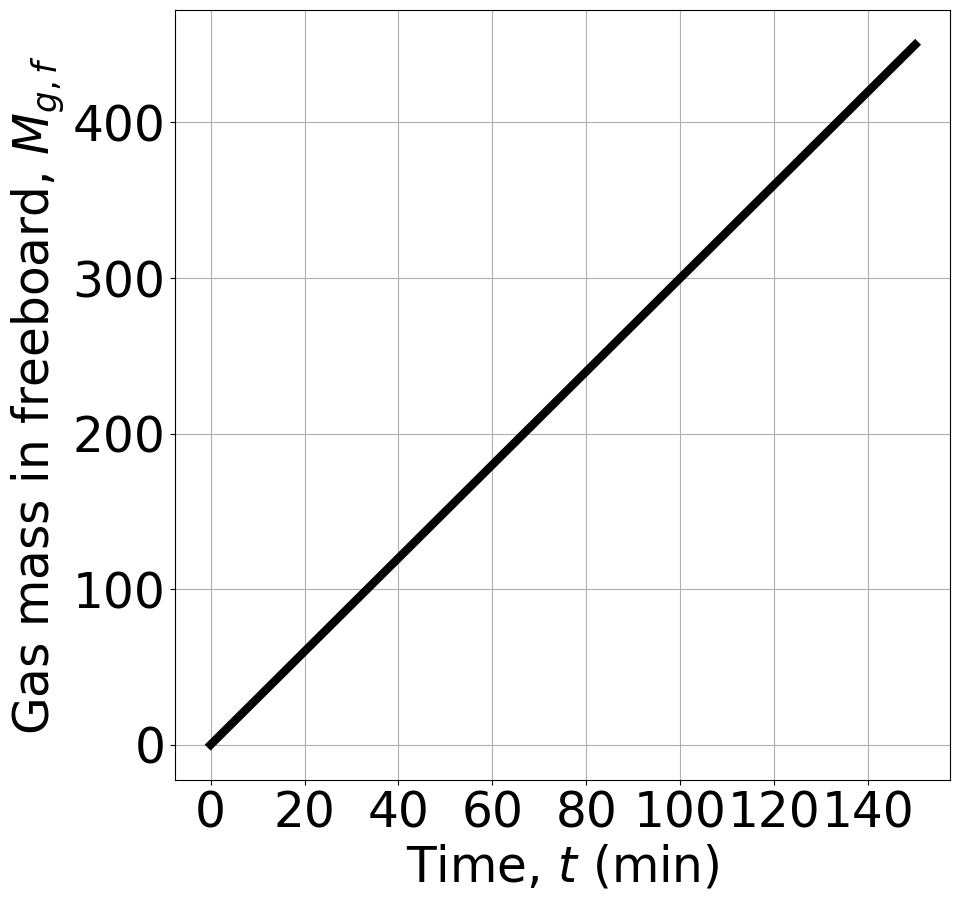

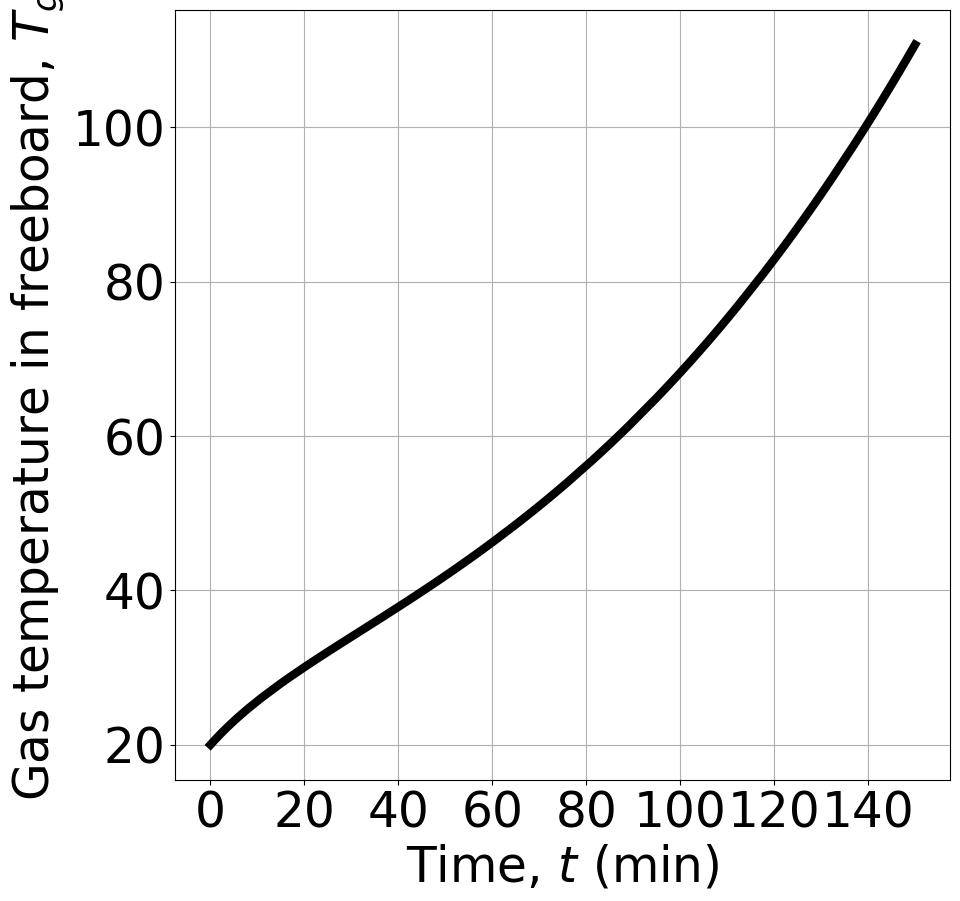

In [ ]:
env = incinerator()

obs, _ = env.reset()

print(obs)
print(env.observation_space)
print(env.action_space)
#print(env.action_space.sample())

Q_ext = 40
Q_ext = ((Q_ext-env.Q_ext_min)/(env.Q_ext_max-env.Q_ext_min))*(1-(-1))+(-1) # normalize to be in [-1,1] before use
Q_ext = [Q_ext] # between '[]' because step() expects this shape

n_steps = 3000000

# For plotting:
vector_t = -np.ones(n_steps+1)
vector_M = -np.ones(n_steps+1)
vector_M_char = -np.ones(n_steps+1)
vector_T_w = -np.ones(n_steps+1)
vector_M_g_w = -np.ones(n_steps+1)
vector_M_g_f = -np.ones(n_steps+1)
vector_T_g = -np.ones(n_steps+1)
vector_t[0] = 0
vector_M[0] = M_ini
vector_M_char[0] = M_char_ini
vector_T_w[0] = T_w_ini
vector_M_g_w[0] = M_g_w_ini
vector_M_g_f[0] = M_g_f_ini
vector_T_g[0] = T_g_ini

for step in range(n_steps):
    obs, reward, truncated, terminated, info = env.step(Q_ext)

    # For plotting:
    vector_t[step+1] = vector_t[step] + env.dt
    vector_M[step+1] = obs[0]
    vector_M_char[step+1] = obs[1]
    vector_T_w[step+1] = obs[2]
    vector_M_g_w[step+1] = obs[3]
    vector_M_g_f[step+1] = obs[4]
    vector_T_g[step+1] = obs[5]

env.render()